In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import PIL
# from scipy.io import wavfile
# import torchaudio
# from IPython.display import Audio, display

# Definimos nuestro device

In [2]:
dev = torch.device("cuda:0" if torch.cuda.is_available()else "cpu")

### Recordar que cada vez que se usa el notebook, ha de cargarse el archivo .json

In [3]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

# Extraemos la URL de donde vamos a extraer el archivo

In [4]:
# En este caso, el archivo es el de perros y gatos
!kaggle datasets download chetankv/dogs-cats-images
!unzip dogs-cats-images.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/t

# Funciones que entrenan al modelo

In [5]:
# En esta celda van las funciones que entrenan al modelo
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

arr_train_loss = []
arr_test_loss = []
arr_train_acc = []
arr_test_acc = []
def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")
    arr_train_loss.append(train_loss)
    arr_test_loss.append(test_loss)
    arr_train_acc.append(train_acc)
    arr_test_acc.append(test_acc)

# Transformaciones a los datos

In [6]:
from torchvision.transforms.transforms import RandomRotation
img_transform = torchvision.transforms.Compose([
  torchvision.transforms.RandomRotation(2),    #Rotamos aleatoriamente algunas imágenes 2°
  torchvision.transforms.RandomHorizontalFlip(), # Con esta línea de código, rotamos aleatoriamente alguna imagen horizontalmente
  torchvision.transforms.Resize((256,256)),      # Con esta línea uniformizamos los tamaños de todas las imágenes 
  torchvision.transforms.ToTensor()             # con esta línea, transfomramos los valores de la imagen a un tensor
])

# Se coloca la dirección donde se encuentra el archivo

In [7]:
train_ds = torchvision.datasets.ImageFolder("/content/dataset/training_set",transform=img_transform)
test_ds = torchvision.datasets.ImageFolder("/content/dataset/test_set",transform=img_transform)

# Información de train_ds y test_ds

In [8]:
train_ds      # Información del conjunto de datos de entrenamiento

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: /content/dataset/training_set
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-2.0, 2.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [9]:
test_ds         # Información del conjunto de datos de testeo

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/dataset/test_set
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-2.0, 2.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

# Viendo las imágenes que se están usando

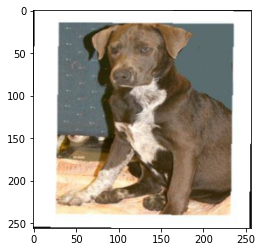

In [10]:
plt.imshow(train_ds[6531][0].numpy().transpose(1,2,0))

# Seleccionar si se trabajará con shuffle = True or False

# Shuffle=True

In [11]:
# Formamos paquetes de 128 datos, y colocamos shuffle=True, esto con el fin que el aprendizaje de la red neuronal se vaya almacenando, y que no se vaya olvidando de lo que ha aprendido
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128,shuffle=True)

# Shuffle = False

In [11]:
# Formamos paquetes de 128 datos, y colocamos shuffle=TFalse, esto con el fin que el aprendizaje de la red neuronal se vaya almacenando, y que no se vaya olvidando de lo que ha aprendido
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128,shuffle=False)

# Creación del modelo

In [12]:
model = nn.Sequential(
  nn.Conv2d(3,16,4,bias=False),  # Nos ayuda a detectar los bordes y características distintivas de la imagen.
  nn.BatchNorm2d(16),            # Es un reescalamiento de los datos, evita que los valores no crezcan descontroladamente
  nn.ReLU(inplace=True),         # Función de activación
  nn.MaxPool2d(2),               # EScoge el máximo, en un kernel de 2x2
  nn.Conv2d(16,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(32,32,2,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(32,64,2,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(64,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(64,128,3,bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Flatten(),                # Aplana el tensor en dos dimensiones
  nn.Linear(512,2)           # Aplica una transformación lineal; el 2, indica la cantidad de salidas que queremos extraer, en este caso, se quieren dos salidas, o perros, o gatos.
).to(dev)

# Entrenamiento de la RED NEURONAL

# SGD, lr=0.1

In [13]:
crit = nn.CrossEntropyLoss()                            # Definimos el Lost
optim = torch.optim.SGD(model.parameters(),lr=0.1)      # Definimos el optimizador
train(model,train_dl, test_dl, crit, optim, epochs=10)  # Entrenamos el modelo

epoch: 0, train loss: 1.7025384136608668, train acc: 53.025%, test loss: 0.740468218922615, test acc: 51.85%
epoch: 1, train loss: 0.9485251969761319, train acc: 58.8%, test loss: 3.9236341565847397, test acc: 50.0%
epoch: 2, train loss: 0.8397539513451713, train acc: 63.425%, test loss: 0.8323601223528385, test acc: 63.75%
epoch: 3, train loss: 0.773705592231145, train acc: 65.8125%, test loss: 0.7078043110668659, test acc: 59.3%
epoch: 4, train loss: 0.733226013562036, train acc: 68.025%, test loss: 0.8141646757721901, test acc: 65.2%
epoch: 5, train loss: 0.6948522220528315, train acc: 70.225%, test loss: 0.6607167534530163, test acc: 68.6%
epoch: 6, train loss: 0.5921510495836773, train acc: 73.2375%, test loss: 0.5801660623401403, test acc: 75.0%
epoch: 7, train loss: 0.525798813691215, train acc: 75.025%, test loss: 1.3890967667102814, test acc: 58.4%
epoch: 8, train loss: 0.4804530806011624, train acc: 77.8375%, test loss: 0.8563048504292965, test acc: 62.5%
epoch: 9, train loss

# Adam, lr=0.01

In [13]:
crit = nn.CrossEntropyLoss()                            # Definimos el Lost
optim = torch.optim.Adam(model.parameters(),lr=0.01)      # Definimos el optimizador
train(model,train_dl, test_dl, crit, optim, epochs=10)  # Entrenamos el modelo

epoch: 0, train loss: 1.7968455394631204, train acc: 86.425%, test loss: 7.040619184583193, test acc: 50.0%
epoch: 1, train loss: 2.8358275353435487, train acc: 42.4%, test loss: 1.3996198503300548, test acc: 50.0%
epoch: 2, train loss: 1.0979317947039529, train acc: 41.625%, test loss: 0.7127082347869873, test acc: 50.0%
epoch: 3, train loss: 0.7457762795781332, train acc: 29.625%, test loss: 0.693511851131916, test acc: 50.0%
epoch: 4, train loss: 0.7327533099386427, train acc: 26.8%, test loss: 0.6941782645881176, test acc: 50.0%
epoch: 5, train loss: 0.7340651769486685, train acc: 26.8375%, test loss: 0.6944818012416363, test acc: 50.0%
epoch: 6, train loss: 0.734767650801038, train acc: 26.8125%, test loss: 0.6947059296071529, test acc: 50.0%
epoch: 7, train loss: 0.7351670880166311, train acc: 25.2%, test loss: 0.6948171108961105, test acc: 50.0%
epoch: 8, train loss: 0.7353229049652342, train acc: 25.2125%, test loss: 0.6948349289596081, test acc: 50.0%
epoch: 9, train loss: 0.7

In [14]:
arr_train_loss

[1.7025384136608668,
 0.9485251969761319,
 0.8397539513451713,
 0.773705592231145,
 0.733226013562036,
 0.6948522220528315,
 0.5921510495836773,
 0.525798813691215,
 0.4804530806011624,
 0.44356204309160746]

In [15]:
(arr_test_loss)

[0.740468218922615,
 3.9236341565847397,
 0.8323601223528385,
 0.7078043110668659,
 0.8141646757721901,
 0.6607167534530163,
 0.5801660623401403,
 1.3890967667102814,
 0.8563048504292965,
 0.48754749074578285]

In [16]:
arr_train_acc

[53.025,
 58.8,
 63.425,
 65.8125,
 68.025,
 70.225,
 73.2375,
 75.025,
 77.8375,
 79.625]

In [17]:
arr_test_acc

[51.85, 50.0, 63.75, 59.3, 65.2, 68.6, 75.0, 58.4, 62.5, 76.55]

# Evaluación de la red neuronal

Perro


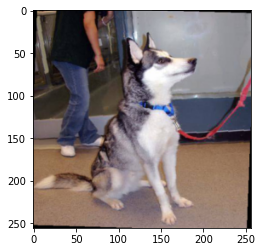

In [18]:
model.eval()
idx = 1000
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

Gato


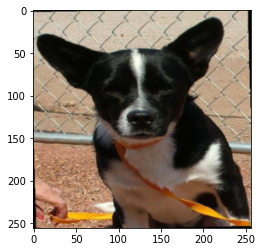

In [19]:
model.eval()
idx = 1030
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

Gato


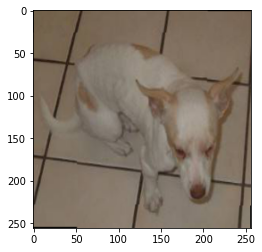

In [20]:
model.eval()
idx = 1997
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

Gato


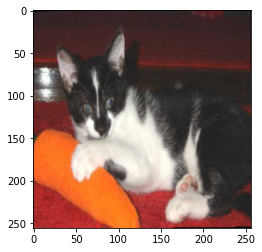

In [21]:
model.eval()
idx = 500
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

Gato


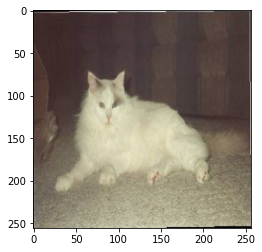

In [22]:
model.eval()
idx = 667
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

Perro


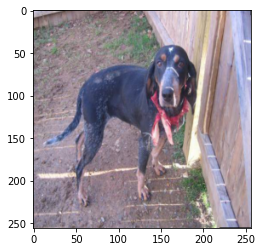

In [23]:
model.eval()
idx = 1577
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

Perro


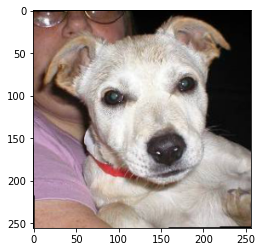

In [24]:
model.eval()
idx = 1234
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

Gato


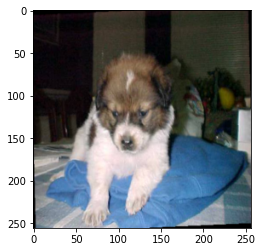

In [25]:
model.eval()
idx = 1576
x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred==0:
  print('Gato')
if pred==1:
  print('Perro')
plt.imshow(x_numpy)

# Gráficas

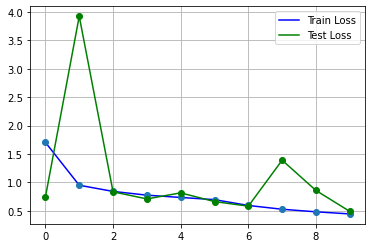

In [26]:
plt.plot(arr_train_loss,'b-',label="Train Loss")
plt.plot(arr_train_loss,'o')
plt.plot(arr_test_loss,'g-',label="Test Loss")
plt.plot(arr_test_loss,'go')
plt.legend()
plt.grid(True)
plt.show()

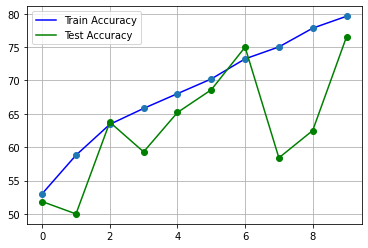

In [27]:
plt.plot(arr_train_acc,'b-',label="Train Accuracy")
plt.plot(arr_train_acc,'o')
plt.plot(arr_test_acc,'g-',label="Test Accuracy")
plt.plot(arr_test_acc,'go')
plt.legend()
plt.grid(True)
plt.show()

Estas últimas gráficas fueron producto de una última compilación antes de entregar el trabajo. Se usaron como parámetros de esta última compilación:
Optimizador: SGD,
shuffle = True.